In [2]:
from ultralytics import YOLO
import cv2
import numpy as np
from PIL import Image

model = YOLO('yolov8x.pt')  # Load a pretrained YOLOv8 model
model.info()

YOLOv8x summary: 365 layers, 68,229,648 parameters, 0 gradients, 258.5 GFLOPs


(365, 68229648, 0, 258.5472512)

In [3]:
image_path = '/Users/ke/Documents/Cal/research/physical-reasoning/demo/demo.jpg'
results = model(image_path)

for result in results:
    boxes = result.boxes
    names = result.names
    
    for box in boxes:
        name = int(box.cls)
        confidence = float(box.conf)
        coord = box.xyxy # tensor of (x1, y1, x2, y2)
        print(f"Predicted {names[name]} with confidence {confidence:.3f} at {coord}")

tensor = results[0].plot()
# show the tensor as an image
from PIL import Image

# convert tensor from BGR to RGB
tensor = tensor[:, :, ::-1]

img = Image.fromarray(tensor, mode='RGB')
img

FileNotFoundError: /Users/ke/Documents/Cal/research/physical-reasoning/demo/demo.jpg does not exist

In [4]:
seg_model = YOLO('yolov8n-seg.pt')  # Load a pretrained YOLOv8 model
model.info()

YOLOv8x summary (fused): 268 layers, 68,200,608 parameters, 0 gradients, 257.8 GFLOPs


(268, 68200608, 0, 257.8145792)

In [5]:
seg_image_path = "/Users/kevinchon/Documents/Research/KD2KC/scenic-reasoning/demo/demo.jpg"

In [6]:

def segment_image(model, image_path, conf_threshold=0.5):
    results = model.predict(
        source=image_path,
        conf=conf_threshold,
        save=False,
        show=False
    )
    
    return results[0]

def visualize_seg_results(image_path, results):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    masks = results.masks.data.cpu().numpy()
    boxes = results.boxes.data.cpu().numpy()
    cls = results.boxes.cls.cpu().numpy()
    
    # Draw each instance
    for mask, box, class_id in zip(masks, boxes, cls):
        # Resize mask to match image dimensions
        mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
        binary_mask = mask > 0.5
        
        # Generate random color
        color = np.random.randint(0, 255, size=3).tolist()
        
        # Create color overlay
        color_mask = np.full(img.shape, color, dtype=np.uint8)
        img = np.where(binary_mask[..., None], 
                      cv2.addWeighted(img, 0.5, color_mask, 0.5, 0),
                      img)
        
        # Draw bounding box
        x1, y1, x2, y2 = box[:4].astype(int)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        
        # Add label
        label = f"{results.names[int(class_id)]} {box[4]:.2f}"
        cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    return img.astype(np.uint8)



image 1/1 /Users/kevinchon/Documents/Research/KD2KC/scenic-reasoning/demo/demo.jpg: 448x640 10 cars, 1 bench, 113.1ms
Speed: 2.7ms preprocess, 113.1ms inference, 3.5ms postprocess per image at shape (1, 3, 448, 640)
segmentation results: ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 

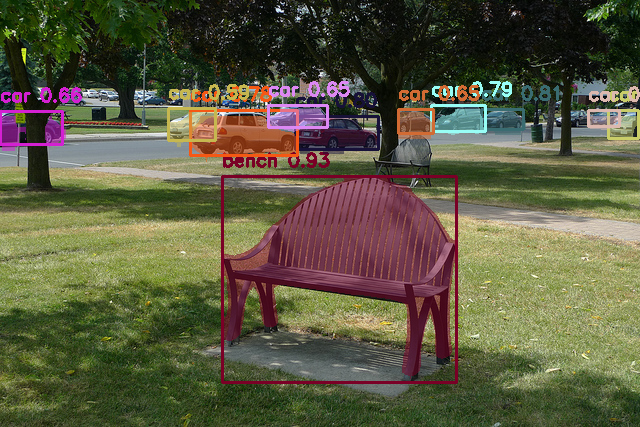

In [9]:
seg_results = segment_image(seg_model,seg_image_path)
seg_annotations = visualize_seg_results(seg_image_path, seg_results)
print(f"segmentation results: {seg_results}")
print(f"segmentation results boxes: {seg_results.boxes}")
print(f"segmentation results masks: {seg_results.masks}")
seg_img = Image.fromarray(seg_annotations, mode='RGB')
seg_img